# Tutorial 18 (JAX): Deep Reinforcement Learning

In [1]:
## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial
from PIL import Image
from collections import defaultdict
from typing import Any, Callable
from types import SimpleNamespace
from copy import deepcopy
from statistics import mean
import pickle
import time

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for progress bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import checkpoints
from flax.training.train_state import TrainState

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial18_jax"

print("Device:", jax.devices()[0])

/home/phillip/anaconda3/envs/dl2020/lib/python3.7/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


Device: gpu:0


In [2]:
try:
    import gym
except ModuleNotFoundError:
    !pip install --quiet gym[all]
    import gym

In [3]:
def jax_to_np_rng(rng):
    return random.randint(rng, shape=(1,), minval=0, maxval=int(1e8), dtype=np.int64).item()

In [4]:
class ObservationsToNumpy(gym.ObservationWrapper):
    
    def observation(self, obs):
        return np.array(obs)

In [5]:
def create_env(env_name='ALE/SpaceInvaders-v5', eval_env=False):
    # Create base environment
    env = gym.make(env_name,
                   full_action_space=False,
                   frameskip=1)
    # Environment preprocessing
    env = gym.wrappers.AtariPreprocessing(env)
    env = gym.wrappers.FrameStack(env, 4)
    env = ObservationsToNumpy(env)
    if not eval_env:
        env = gym.wrappers.TransformReward(env, lambda r: max(min(1., r), -1.))
    # Set maximum episode length
    if 'Pong' in env_name:
        env.spec.max_episode_steps = 5000
    else:
        env.spec.max_episode_steps = 10000
    return env

In [6]:
env = create_env('ALE/SpaceInvaders-v5')
eval_env = create_env('ALE/SpaceInvaders-v5', eval_env=True)

## Deep Q-Network

### Network architecture

For the network architecture, we follow previous work [Mnih et al., 2015; van Hasselt et al., 2016] and use a 3 layer convolutional network as a feature extractor. The input is a stack of frames from the Atari environment. Since the previous frames are only needed to extract movement, we represent them by taking discrete differences between frames. In other words, we want the input to be $[x, \dot{x}, \ddot{x}]$. This stack is then processed by a small ConvNet. Note that since we have to run this network several times per environment, we do not overparameterize it, as common for (un-)supervised task.

In [7]:
class Backbone(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        x = x.astype(jnp.float32) / 255. * 2. - 1.
        # Represent framestack as discrete differences, i.e. x, dx/dt, d^2x/dt
#         x = jnp.concatenate([x[:,2] - 2 * x[:,1] + x[:,0],
#                              x[:,2] - x[:,1], 
#                              x[:,2]], 
#                             axis=-1)
        x = jnp.transpose(x, (0, 2, 3, 1))
        # Convolutional block
        x = nn.Conv(32, kernel_size=(8, 8), strides=(4, 4), padding=0)(x)  # 84 => 20
        x = nn.relu(x)
        x = nn.Conv(64, kernel_size=(4, 4), strides=(2, 2), padding=0)(x)  # 20 => 9
        x = nn.relu(x)
        x = nn.Conv(64, kernel_size=(3, 3), strides=(1, 1), padding=0)(x)
        x = nn.relu(x)
        x = x.reshape(x.shape[0], -1)
        return x

These features are used now to build up the DQN. The DQN network produces as output $q(s,\cdot)$, which means we need one value per action. Hence, based on the features coming out of the backbone, we apply two linear layers, with the last one having $|\mathcal{A}|$ outputs:

In [8]:
class DQN(nn.Module):
    num_actions : int
    
    @nn.compact
    def __call__(self, x):
        x = Backbone()(x)
        x = nn.Dense(1024)(x)
        x = nn.relu(x)
        q = nn.Dense(self.num_actions,
                     kernel_init=nn.initializers.zeros)(x)
        return q

Following common practice, we initialize the last layer with zeros. This is mainly to start with a zero TD error for states with zero and prevent introducing unnecessary noise to the TD error. To understand the network a bit better, let's tabulate it below:

In [9]:
s, _ = env.reset()
print(DQN(env.action_space.n).tabulate(random.PRNGKey(0), s[None]))

                              DQN Summary                               
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path              ┃ outputs             ┃ params                     ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs            │ uint8[1,4,84,84]    │                            │
├───────────────────┼─────────────────────┼────────────────────────────┤
│ Backbone_0/Conv_0 │ float32[1,20,20,32] │ bias: float32[32]          │
│                   │                     │ kernel: float32[8,8,4,32]  │
│                   │                     │                            │
│                   │                     │ 8,224 (32.9 KB)            │
├───────────────────┼─────────────────────┼────────────────────────────┤
│ Backbone_0/Conv_1 │ float32[1,9,9,64]   │ bias: float32[64]          │
│                   │                     │ kernel: float32[4,4,32,64] │
│                   │                     │                            │
│                   │                     │ 32,832 (131.3 KB)          │
├───────────────────┼─────────────────────┼────────────────────────────┤
│ Backbone_0/Conv_2 │ float32[1,7,7,64]   │ bias: float32[64]          │
│                   │                     │ kernel: float32[3,3,64,64] │
│                   │                     │                            │
│                   │                     │ 36,928 (147.7 KB)          │
├───────────────────┼─────────────────────┼────────────────────────────┤
│ Backbone_0        │ float32[1,3136]     │                            │
├───────────────────┼─────────────────────┼────────────────────────────┤
│ Dense_0           │ float32[1,1024]     │ bias: float32[1024]        │
│                   │                     │ kernel: float32[3136,1024] │
│                   │                     │                            │
│                   │                     │ 3,212,288 (12.8 MB)        │
├───────────────────┼─────────────────────┼────────────────────────────┤
│ Dense_1           │ float32[1,6]        │ bias: float32[6]           │
│                   │                     │ kernel: float32[1024,6]    │
│                   │                     │                            │
│                   │                     │ 6,150 (24.6 KB)            │
├───────────────────┼─────────────────────┼────────────────────────────┤
│ DQN               │ float32[1,6]        │                            │
├───────────────────┼─────────────────────┼────────────────────────────┤
│                   │               Total │ 3,296,422 (13.2 MB)        │
└───────────────────┴─────────────────────┴────────────────────────────┘
                                                                        
                 Total Parameters: 3,296,422 (13.2 MB)                  

Most parameters sit in the first linear layer, allowing for reasoning about features across the whole image. 

### Experience Replay

In [10]:
class ExperienceReplayBuffer:
    
    def __init__(self, capacity=250000):
        self.capacity = capacity
        self.buffer = list()
        self.probs = list()
        
    def __len__(self):
        return len(self.buffer)
        
    def add(self, s, s_next, action, reward, done, prob=1.0):
        while len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
            self.probs.pop(0)
        self.buffer.append((s, s_next, action, reward, done))
        self.probs.append(prob)
        
    def sample(self, batch_size):
        probs = np.array(self.probs)
        probs = probs / probs.sum()
        trans_idxs = np.random.choice(len(self.buffer), 
                                      batch_size, 
                                      replace=len(self.buffer) <= batch_size,
                                      p=probs)
        transitions = [self.buffer[idx] for idx in trans_idxs]
        transitions = tuple(np.stack(t, axis=0) for t in zip(*transitions))
        return transitions
    
    def avg_reward(self):
        rewards = [b[3] for b in self.buffer]
        return mean(rewards)
    
    def clear(self):
        self.buffer.clear()
        self.probs.clear()

### Exploration policy

In [11]:
class LinearEpsilonScheduler:
    
    def __init__(self, max_iters, steps=None):
        super().__init__()
        self.max_iters = max_iters
        self.steps = steps
        if self.steps is None:
            self.steps = [(0, 1.0), (1./3, 0.1), (2./3, 0.01)]
        self.iter = 0
        
    def get_eps(self, take_iter=True):
        if take_iter:
            self.iter += 1
        
        val = self.iter / self.max_iters
        if val < self.steps[0][0]:
            return self.steps[0][1]
        for i in range(1, len(self.steps)):
            if self.steps[i][0] > val:
                x_diff = self.steps[i][0] - self.steps[i-1][0]
                y_diff = self.steps[i][1] - self.steps[i-1][1]
                v_diff = val - self.steps[i-1][0]
                return self.steps[i-1][1] + v_diff * y_diff / x_diff
        return self.steps[-1][1]

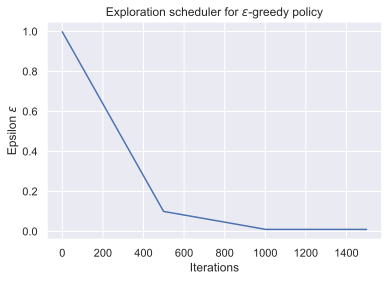

In [12]:
scheduler = LinearEpsilonScheduler(max_iters=1500)
eps_vals = [scheduler.get_eps(take_iter=True) for _ in range(scheduler.max_iters)]
sns.set()
plt.plot(eps_vals)
plt.xlabel('Iterations')
plt.ylabel('Epsilon $\epsilon$')
plt.title('Exploration scheduler for $\epsilon$-greedy policy')
plt.show()

In [13]:
@jax.jit
def sample_action(state, inps, rng, eps=0.0):
    if len(inps.shape) == 2:
        q_vals = inps
    else:
        q_vals = state.apply_fn(state.params, inps)
    # Epsilon-greedy policy
    q_argmax = q_vals.argmax(axis=-1)
    probs = jax.nn.one_hot(q_argmax, num_classes=q_vals.shape[-1]) * (1 - eps) + eps / q_vals.shape[-1]
    actions = random.categorical(rng, jnp.log(jnp.maximum(probs, 1e-10)), axis=-1)
    # q-value of selected action
    act_q_vals = q_vals[jnp.arange(actions.shape[0]), actions]
    return actions, act_q_vals

@jax.jit
def apply_model(state, params, imgs):
    return state.apply_fn(params, imgs)

### TD Error Function

In [14]:
def td_error_func(reward, q_vals, target_q, done, gamma):
    target = reward + (1 - done) * gamma * target_q.max(axis=-1)
    error = target - q_vals
    return error

In [15]:
def clipped_mse(error):
    diff = jnp.abs(error)
    return jnp.where(diff > 1.0, diff, diff**2)

### Training setup

In [16]:
def eval_episode(state, env, seed, eps=0.0):
    env.seed(seed)
    s, _ = env.reset()
    rng = random.PRNGKey(seed)
    rew_return = 0.0
    for t in range(env.spec.max_episode_steps):
        rng, step_rng = random.split(rng)
        a, _ = sample_action(state, s[None], step_rng, eps=eps)
        a = a.item()
        s, r, terminated, truncated, _ = env.step(a)
        rew_return += r
        done = terminated or truncated
        if done:
            return (True, t, rew_return)
    return (False, t, rew_return)

def eval_policy(state, env, num_seeds=100):
    start_time = time.time()
    wins, steps, returns = zip(*[eval_episode(state, env, seed=i, eps=0.0) for i in range(num_seeds)])
    win_prop = mean(wins)
    avg_steps = mean(steps)
    avg_return = mean(returns)
    unsolved = [i for i in range(len(wins)) if not wins[i]]
    end_time = time.time()
    return {'wins': win_prop, 
            'steps': avg_steps, 
            'returns': avg_return, 
            'unsolved': unsolved, 
            'eval_time': end_time - start_time,
            'all_returns': returns,
            'num_seeds': num_seeds}

In [17]:
class QTrainer:
    
    def __init__(self, 
                 env : gym.Env, 
                 eval_env : gym.Env = None,
                 seed : int = 42,
                 lr : float = 2.5e-4,
                 gamma : float = 0.99,
                 train_freq : int = 4,
                 eval_freq : int = 25000,
                 target_freq : int = 10000,
                 buffer_warmup : int = 50000,
                 batch_size : int = 32,
                 scheduler_fn : Any = LinearEpsilonScheduler,
                 model_name : str = "DQN"):
        super().__init__()
        self.env = env
        self.eval_env = eval_env
        if self.eval_env is None:
            self.eval_env = deepcopy(env)
        self.train_freq = train_freq
        self.eval_freq = eval_freq
        self.target_freq = target_freq
        self.buffer_warmup = buffer_warmup
        self.batch_size = batch_size
        self.scheduler_fn = scheduler_fn
        self.lr = lr
        self.gamma = gamma
        self.create_model()
        self.init(seed)
        self.create_train_step()
        self.buffer = ExperienceReplayBuffer()
        env_name = env.unwrapped.spec.id.replace('/', '_')
        self.log_dir = os.path.join(CHECKPOINT_PATH,
                                    f'{model_name}/{env_name}_seed_{seed}/')
        self.logger = SummaryWriter(self.log_dir)
        self.all_evals = {}
        
    def create_model(self):
        self.model = DQN(num_actions=self.env.action_space.n)
        
    def init(self, seed):
        rng = random.PRNGKey(seed)
        rng, init_rng, env_rng = random.split(rng, 3)
        self.env.seed(jax_to_np_rng(env_rng))
        s, _ = self.env.reset()
        params = self.model.init(init_rng, s[None])
        optimizer = optax.chain(
            optax.clip_by_global_norm(10),
            optax.adam(self.lr)
        )
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=params,
                                       tx=optimizer)
        self.rng = rng
        
    def create_train_step(self):
        self.create_loss_fn()
        def train_step(state, target_params, batch):
            loss, grads = jax.value_and_grad(self.loss_fn)(state.params,
                                                           state,
                                                           target_params,
                                                           batch)
            state = state.apply_gradients(grads=grads)
            return state, loss
        self.train_step = jax.jit(train_step)
        
    def create_loss_fn(self):
        def loss_fn(params, state, target_params, batch):
            s, s_next, action, reward, done = batch
            q_current = state.apply_fn(params, s)
            q_next = state.apply_fn(target_params, s_next)
            q_current = q_current[np.arange(action.shape[0]), 
                                  action.astype(np.int32)]
            error = td_error_func(reward, q_current, q_next, done, self.gamma)
            loss = clipped_mse(error)
            return loss.mean()
        self.loss_fn = loss_fn
        
    def init_environment_state(self):
        self.rng, env_rng = random.split(self.rng, 2)
        self.env.seed(jax_to_np_rng(env_rng))
        s, info = self.env.reset()
        self.env_state = {
            'last_state': s,
            'last_lives': info['lives']
        }
        
    def take_environment_step(self, eps):
        self.rng, step_rng = random.split(self.rng)
        s = self.env_state['last_state']
        a, _ = sample_action(self.state, 
                             s[None], 
                             step_rng, 
                             eps=eps)
        a = a.item()
        s_next, r, done, _, info = self.env.step(a)
        life_loss = info['lives'] < self.env_state['last_lives']
        self.buffer.add(s, s_next, a, r, done or life_loss)
        if done:
            self.rng, env_rng = random.split(self.rng)
            env.seed(jax_to_np_rng(env_rng))
            s_next, _ = self.env.reset()
        self.env_state['last_state'] = s_next
        self.env_state['last_lives'] = info['lives']
    
    def train_model(self, num_steps=500000):
        self.target_params = self.state.params
        eps_scheduler = self.scheduler_fn(num_steps)
        eval_env = self.eval_env
        self.init_environment_state()
        losses = []
        for step_idx in tqdm(range(1, num_steps + 1)):
            train_eps = eps_scheduler.get_eps()
            self.take_environment_step(eps=train_eps)
            if len(self.buffer) < self.buffer_warmup:
                continue
            
            if step_idx % self.train_freq == 0:
                batch = self.buffer.sample(self.batch_size)
                self.state, loss = self.train_step(self.state, self.target_params, batch)
                losses.append(loss.item())
                if len(losses) >= 50:
                    self.logger.add_scalar('train/loss', mean(losses), global_step=step_idx)
                    self.logger.add_scalar('train/avg_reward', self.buffer.avg_reward(), global_step=step_idx)
                    losses.clear()
            
            if step_idx % self.eval_freq == 0:
                eval_dict = eval_policy(self.state, eval_env, num_seeds=10)
                self.logger.add_scalar('val/wins', 
                                       eval_dict['wins'], 
                                       global_step=step_idx)
                self.logger.add_scalar('val/steps', 
                                       eval_dict['steps'], 
                                       global_step=step_idx)
                self.logger.add_scalar('val/returns', 
                                       eval_dict['returns'], 
                                       global_step=step_idx)
                self.save_eval(eval_dict, step_idx)
                self.save_model(step_idx)
                
            if step_idx % self.target_freq == 0:
                self.target_params = self.state.params
                
            if step_idx % 1000 == 0:
                self.logger.add_scalar('train/eps', train_eps, global_step=step_idx)
        
        # Testing model
        test_dict = eval_policy(self.state, eval_env, num_seeds=100)
        self.logger.add_scalar('test/returns', 
                               test_dict['returns'], 
                               global_step=num_steps)
        self.save_eval(test_dict, 'test')
        # Finalize training
        self.buffer.clear()
        self.logger.flush()
                
    def save_eval(self, eval_dict, key):
        self.all_evals[key] = eval_dict
        with open(os.path.join(self.log_dir, 'evals.pik'), 'wb') as f:
            pickle.dump(self.all_evals, f)
            
    def load_eval(self):
        with open(os.path.join(self.log_dir, 'evals.pik'), 'rb') as f:
            self.all_evals = pickle.load(f)
        
    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target=self.state.params,
                                    step=step,
                                    overwrite=True)
        
    def load_model(self):
        params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        self.state = self.state.replace(params=params)

### Training a model

In [18]:
def train_models(trainer_class, env, num_seeds, eval_env=None, seed_offset=42):
    trainers = []
    for seed in range(num_seeds):
        trainer = trainer_class(env=env, 
                                eval_env=eval_env, 
                                seed=seed_offset + seed, 
                                eval_freq=25000, 
                                target_freq=10000)
        trainer.train_model(num_steps=1500000)
        trainers.append(trainer)
    return trainers

In [19]:
q_trainers = train_models(QTrainer, env, eval_env=eval_env, num_seeds=1)

  0%|          | 0/1500000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Visualizing learned Q function

In [ ]:
def visualize_value_func(state, seed):
    env.seed(seed)
    env.reset()
    print(env.pos)
    env_states = []
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            env.pos = np.array([i, j])
            env_states.append(env._render_img())
    env_states = np.stack(env_states, axis=0)        
    q_vals = state.apply_fn(state.params, env_states)
    v_vals = q_vals.max(axis=-1)
    v_vals = v_vals.reshape(env.grid_size, env.grid_size)
    v_vals = jax.device_get(v_vals)
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(v_vals)
    ax[1].imshow(env_states[0])
    plt.show()
    print(v_vals)
    
# visualize_value_func(state, seed=eval_dict['unsolved'][0])

## Improving DQN

### Prioritized Experience Replay

In [ ]:
class QPrioTrainer(QTrainer):
    
    def __init__(self, *args, 
                 prio_alpha : float = 0.6,
                 prio_eps : float = 1e-5,
                 model_name : str = 'DQN_Prio',
                 **kwargs):
        super().__init__(*args, 
                         model_name=model_name, 
                         **kwargs)
        self.prio_alpha = prio_alpha
        self.prio_eps = prio_eps
        self.create_prio_fn()
        
    def create_prio_fn(self):
        def get_prio_td_error(state, target_params, r, q_vals, s_next, done):
            target_q = apply_model(state, target_params, s_next[None])
            td_error = td_error_func(r, q_vals, target_q, done, self.gamma)
            return td_error
        self.get_prio_td_error = jax.jit(get_prio_td_error)
        
    def take_environment_step(self, eps):
        self.rng, step_rng = random.split(self.rng)
        s = self.env_state['last_state']
        a, q_vals = sample_action(self.state, 
                                  s[None], 
                                  step_rng, 
                                  eps=eps)
        a = a.item()
        s_next, r, done, _, _ = self.env.step(a)
        td_error = self.get_prio_td_error(self.state, self.target_params,
                                          r, q_vals, s_next, done)
        sample_prob = (abs(td_error.item()) + self.prio_eps) ** self.prio_alpha
        self.buffer.add(s, s_next, a, r, done, prob=sample_prob)
        if done:
            self.rng, env_rng = random.split(self.rng)
            self.env.seed(jax_to_np_rng(env_rng))
            s_next, _ = self.env.reset()
        self.env_state['last_state'] = s_next

In [ ]:
qprio_trainers = train_models(QPrioTrainer, env, eval_env=eval_env, num_seeds=1)

In [ ]:
qprio_trainers[0].all_evals

### Double Q-Learning

Just description on Double Q-Learning, we can combine it with the next one

In [ ]:
@jax.jit
def doubleQ_error_func(reward, q_vals, q_next, target_q, done, gamma):
    target_q = target_q[jnp.arange(target_q.shape[0]),
                        q_next.argmax(axis=-1)]
    target = reward + (1 - done) * gamma * target_q
    error = target - q_vals
    return error

In [ ]:
class DoubleQTrainer(QPrioTrainer):
    
    def __init__(self, *args,
                 model_name : str = 'DoubleDQN',
                 **kwargs):
        super().__init__(*args, model_name=model_name, **kwargs)
        self.create_prio_fn()
    
    def create_loss_fn(self):
        def loss_fn(params, state, target_params, batch):
            s, s_next, action, reward, done = batch
            q = state.apply_fn(params, jnp.concatenate([s, s_next], axis=0))
            q_current, q_next = q.split(2, axis=0)
            q_target = state.apply_fn(target_params, s_next)
            q_current = q_current[np.arange(action.shape[0]), 
                                  action.astype(np.int32)]
            error = doubleQ_error_func(reward, q_current, q_next, q_target, done, self.gamma)
            loss = clipped_mse(error)
            return loss.mean()
        self.loss_fn = loss_fn
        
    def create_prio_fn(self):
        def get_prio_td_error(state, target_params, r, q_vals, s_next, done):
            target_q = apply_model(state, target_params, s_next[None])
            orig_next_q = apply_model(state, state.params, s_next[None])
            td_error = doubleQ_error_func(r, q_vals, orig_next_q, target_q, done, self.gamma)
            return td_error, orig_next_q
        self.get_prio_td_error = jax.jit(get_prio_td_error)
        
    def take_environment_step(self, eps):
        self.rng, step_rng = random.split(self.rng)
        s = self.env_state['last_state']
        a, q_vals = sample_action(self.state, 
                                  self.env_state.get('last_qvals', s[None]), 
                                  step_rng, 
                                  eps=eps)
        a = a.item()
        s_next, r, done, _, _ = self.env.step(a)
        td_error, next_q = self.get_prio_td_error(self.state, 
                                                  self.target_params, 
                                                  r, 
                                                  q_vals, 
                                                  s_next, 
                                                  done)
        self.env_state['last_qvals'] = next_q
        sample_prob = (abs(td_error.item()) + self.prio_eps) ** self.prio_alpha
        self.buffer.add(s, s_next, a, r, done, prob=sample_prob)
        if done:
            self.env_state.pop('last_qvals')
            self.rng, env_rng = random.split(self.rng)
            self.env.seed(jax_to_np_rng(env_rng))
            s_next, _ = self.env.reset() # env_rng)
        self.env_state['last_state'] = s_next

In [ ]:
doubleq_trainers = train_models(DoubleQTrainer, env, eval_env=eval_env, num_seeds=1)

### Dueling DQN

In [ ]:
class DuelingDQN(nn.Module):
    num_actions : int
    
    @nn.compact
    def __call__(self, x, return_separate=False):
        x = Backbone()(x)
        v = nn.Dense(512, name='v_linear')(x)
        v = nn.relu(v)
        v = nn.Dense(1, name='v_output',
                     kernel_init=nn.initializers.zeros)(v)
        a = nn.Dense(512, name='a_linear')(x)
        a = nn.relu(a)
        a = nn.Dense(self.num_actions, name='a_output',
                     kernel_init=nn.initializers.zeros)(a)
        a = a - a.mean(axis=-1, keepdims=True)
        q = v + a
        
        if not return_separate:
            return q
        else:
            return q, {'v': v, 'a': a}

In [ ]:
s, _ = env.reset()
print(DuelingDQN(env.action_space.n).tabulate(random.PRNGKey(0), s[None]))

In [ ]:
class DuelingQTrainer(DoubleQTrainer):
    
    def __init__(self, *args,
                 model_name : str = 'DuelingDQN',
                 **kwargs):
        super().__init__(*args, model_name=model_name, **kwargs)
    
    def create_model(self):
        self.model = DuelingDQN(num_actions=self.env.action_space.n)

In [ ]:
duelingq_trainers = train_models(DuelingQTrainer, env, eval_env=eval_env, num_seeds=1)

## Conclusion

## References

[Mnih et al., 2015] Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ... & Hassabis, D. (2015). Human-level control through deep reinforcement learning. nature, 518(7540), 529-533. ([link](https://daiwk.github.io/assets/dqn.pdf))

[van Hasselt et al., 2016] Van Hasselt, H., Guez, A., & Silver, D. (2016). Deep reinforcement learning with double q-learning. In Proceedings of the AAAI conference on artificial intelligence (Vol. 30, No. 1). ([link](https://ojs.aaai.org/index.php/AAAI/article/download/10295/10154))

[Wang et al., 2016] Wang, Z., Schaul, T., Hessel, M., Hasselt, H., Lanctot, M., & Freitas, N. (2016). Dueling network architectures for deep reinforcement learning. In International conference on machine learning (pp. 1995-2003). PMLR. ([link](https://arxiv.org/pdf/1511.06581.pdf))

[Arulkumaran et al., 2017] Arulkumaran, K., Deisenroth, M. P., Brundage, M., & Bharath, A. A. (2017). Deep reinforcement learning: A brief survey. IEEE Signal Processing Magazine, 34(6), 26-38. ([link](https://discovery.ucl.ac.uk/id/eprint/10083557/1/1708.05866v2.pdf))
